In [3]:
using RigidBodyDynamics
using ForwardDiff
using Plots

In [4]:
struct Model
    f::Function # continuous dynamics (ie, differential equation)
    n::Int # number of states
    m::Int # number of controls

    function Model(f::Function, n::Int64, m::Int64)
        # construct a model from an explicit differential equation
        new(f,n,m)
    end

    function Model(mech::Mechanism)
        # fully actuated
        m = length(joints(mech))-1  # subtract off joint to world
        Model(mech,ones(m,1))
    end

    function Model(mech::Mechanism,torques::Array)

        # construct a model using robot dynamics equation assembed from URDF file
        n = num_positions(mech) + num_velocities(mech) + num_additional_states(mech)
        num_joints = length(joints(mech))-1  # subtract off joint to world
        m = num_joints # Default to number of joints

        function fc(x,u)
            state = MechanismState{eltype(x)}(mech)

            # set the state variables:
            q = x[1:num_joints]
            qd = x[(1:num_joints)+num_joints]
            set_configuration!(state, q)
            set_velocity!(state, qd)

            [qd; Array(mass_matrix(state))\(torques.*u) - Array(mass_matrix(state))\Array(dynamics_bias(state))]
        end
        new(fc, n, convert(Int,sum(torques)))
    end
end

function Model(urdf::String)
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech)
end

function Model(urdf::String,torques::Array{Float64,1})
    # underactuated system (potentially)
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech,torques)
end

Model

In [5]:
# cost function
mutable struct Objective
    Q::Array{Float64,2}
    R::Array{Float64,2}
    Qf::Array{Float64,2}
    tf::Float64
    x0::Array{Float64,1}
    xf::Array{Float64,1}
end

In [6]:
struct Solver
    model::Model
    obj::Objective
    dt::Float64
    fd::Function  # discrete dynamics
    F::Function
    N::Int

    function Solver(model::Model, obj::Objective, discretizer::Function=rk4; dt=0.01)
        fd = discretizer(model.f, dt)     # Discrete dynamics
        f_aug = f_augmented(model)  # Augmented continuous dynamics
        fd_aug = discretizer(f_aug)  # Augmented discrete dynamics
        F(S) = ForwardDiff.jacobian(fd_aug, S)

        function Jacobians(x::Array,u::Array)
            F_aug = F([x;u;dt])
            fx = F_aug[1:model.n,1:model.n]
            fu = F_aug[1:model.n,model.n+1:model.n+model.m]
            return fx, fu
        end

        N = Int(floor(obj.tf/dt));
        new(model, obj, dt, fd, Jacobians, N)
    end
end

# Midpoint Integrator
function f_midpoint(f::Function, dt::Float64)
    dynamics_midpoint(x,u)  = x + f(x + f(x,u)*dt/2, u)*dt
end

function f_midpoint(f::Function)
    dynamics_midpoint(S::Array)  = S + f(S + f(S)*S[end]/2)*S[end]
end

# RK4 Integrator
function rk4(f::Function,dt::Float64)
    # Runge-Kutta 4
    k1(x,u) = dt*f(x,u)
    k2(x,u) = dt*f(x + k1(x,u)/2.,u)
    k3(x,u) = dt*f(x + k2(x,u)/2.,u)
    k4(x,u) = dt*f(x + k3(x,u), u)
    fd(x,u) = x + (k1(x,u) + 2.*k2(x,u) + 2.*k3(x,u) + k4(x,u))/6.
end

function rk4(f_aug::Function)
    # Runge-Kutta 4
    fd(S::Array) = begin
        k1(S) = S[end]*f_aug(S)
        k2(S) = S[end]*f_aug(S + k1(S)/2.)
        k3(S) = S[end]*f_aug(S + k2(S)/2.)
        k4(S) = S[end]*f_aug(S + k3(S))
        S + (k1(S) + 2.*k2(S) + 2.*k3(S) + k4(S))/6.
    end
end

# Assembled augmented function
function f_augmented(model::Model)
    f_aug = f_augmented(model.f, model.n, model.m)
    f(S::Array) = [f_aug(S); zeros(model.m+1,1)]
end

function f_augmented(f::Function, n::Int, m::Int)
    f_aug(S::Array) = f(S[1:n], S[n+(1:m)])
end

f_augmented (generic function with 2 methods)

In [137]:
#iLQR

function rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, alpha::Float64, X_::Array{Float64,2}, U_::Array{Float64,2})
    N = solver.N
    m = solver.model.m
    X_[:,1] = solver.obj.x0;
    for k = 2:N
        a = alpha*(d[:,k-1]);
        delta = (X_[:,k-1] - X[:,k-1])

        U_[:, k-1] = U[:, k-1] - K[:,:,k-1]*delta - a;
        X_[:,k] = solver.fd(X_[:,k-1], U_[1:m,k-1]) + U_[m+1:end,k-1] # <- note the artificial control term
        
        if ~all(isfinite, X_[:,k]) || ~all(isfinite, U_[:,k-1])
            return false
        end
    end
    return true
end

function cost(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    N = solver.N
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf

    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

# overloaded cost function to accomodate Augmented Lagrance method
function cost(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},C::Array{Float64,2},I_mu::Array{Float64,3},LAMBDA::Array{Float64,2})
    J = cost(solver,X,U)
    for k = 1:solver.N
        J += 0.5*(C[:,k]'*I_mu[:,:,k]*C[:,k] + LAMBDA[:,k]'*C[:,k])
    end
    if J < 0.0
        println("NEGATIVE COST PROBLEM!")
        println(LAMBDA)
        println(size(LAMBDA,1)*size(LAMBDA,2))
        println(sum(LAMBDA.*C.<0.))
        println(LAMBDA.*C.<0.)
        
    end
    return J
end

function backwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2},C::Array{Float64,2},Cx::Array{Float64,3},Cu::Array{Float64,3},I_mu::Array{Float64,3},LAMBDA::Array{Float64,2})
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf 

    S = Qf + Cx[:,:,N]'*I_mu[:,:,N]*Cx[:,:,N]
    s = Qf*(X[:,N] - xf) + Cx[:,:,N]'*I_mu[:,:,N]*C[:,N] + Cx[:,:,N]'*LAMBDA[:,N]
    v1 = 0.
    v2 = 0.

    mu = 0.
    k = N-1
    while k >= 1
        lx = Q*(X[:,k] - xf)
        lu = R*(U[:,k])
        lxx = Q
        luu = R
        fx, fu = solver.F(X[:,k],U[1:m,k])
        fu = [fu eye(n)] # augmented normal Jacobian with identity
        Qx = lx + fx'*s 
        Qu = lu + fu'*s 
        Qxx = lxx + fx'*S*fx
        Quu = luu + fu'*(S + mu*eye(n))*fu
        Qux = fu'*(S + mu*eye(n))*fx

#         # regularization
#         if any(eigvals(Quu).<0.)
#             mu = mu + 1.0;
#             k = N-1;
#             println("regularized")
#         end
        
        # Constraints
        Qx += Cx[:,:,k]'*I_mu[:,:,k]*C[:,k] + Cx[:,:,k]'*LAMBDA[:,k]
        Qu += Cu[:,:,k]'*I_mu[:,:,k]*C[:,k] + Cu[:,:,k]'*LAMBDA[:,k]
        Qxx += Cx[:,:,k]'*I_mu[:,:,k]*Cx[:,:,k]
        Quu += Cu[:,:,k]'*I_mu[:,:,k]*Cu[:,:,k]
        Qux += Cu[:,:,k]'*I_mu[:,:,k]*Cx[:,:,k]
        
        K[:,:,k] = Quu\Qux
        d[:,k] = Quu\Qu
        s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
        S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]

        # terms for line search
        v1 += float(d[:,k]'*Qu)[1]
        v2 += float(d[:,k]'*Quu*d[:,k])

        k = k - 1;
    end
    return K, d, v1, v2
end



function forwardpass!(X_, U_, solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, v1::Float64, v2::Float64, C_function::Function,I_mu_function::Function,LAMBDA::Array{Float64,2},MU::Array{Float64,2}, c1::Float64=1e-4, c2::Float64=1.0)
    m = solver.model.m
    n = solver.model.n
    # Compute original cost
    J_prev = cost(solver, X, U, C_function(X,U), I_mu_function(X,U,LAMBDA,MU), LAMBDA)

    J = Inf
    alpha = 1.0
    iter = 0
    dV = Inf
    z = 0.

    while z < c1 || z > c2
        flag = rollout!(solver, X, U, K, d, alpha, X_, U_)

        # Check if rollout completed
        if ~flag
            # println("Bad X bar values")
            alpha /= 2.
            continue
        end

        # Calcuate cost
        
        J = cost(solver, X_, U_, C_function(X_,U_), I_mu_function(X_,U_,LAMBDA,MU), LAMBDA)
        dV = alpha*v1 + (alpha^2)*v2/2.
        z = (J_prev - J)/dV[1,1]
        if iter < 10
            alpha = alpha/2.
        else
            alpha = alpha/10.
        end
        iter = iter + 1
        
#         println("- Expected improvement: $(dV[1])")
#         println("- Actual improvement: $(J_prev-J)")
#         println("- (z = $z)\n")

        if iter > 20
            println("^^^max iterations (forward pass)^^^")
            rollout!(solver, X, U, K, d, 0.0, X_, U_) #probably unnecessary 
            break
        end
        iter += 1
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(J_prev-J)")
    println("- (z = $z)\n")

    return J

end

function solve(solver::Solver)
    U = zeros(solver.model.m, solver.N)
    solve(solver,U)
end

solve (generic function with 4 methods)

In [248]:
function bias(solver::Solver,X_init::Array{Float64,2},U_init::Array{Float64,2})
    b = zeros(solver.model.n,solver.N-1)
    X = zeros(solver.model.n,solver.N)
    X[:,1] = X_init[:,1]
    for k = 1:solver.N-1
        X[:,k+1] = solver.fd(X[:,k],U_init[:,k])
        b[:,k] = X_init[:,k+1] - X[:,k+1]
        X[:,k+1] += b[:,k]
    end
    X, b
end

function solve(solver::Solver,X_init::Array{Float64,2},U_init::Array{Float64,2},iterations::Int64=100,eps::Float64=1e-3)
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    m_aug = m + n
    iter_outer = 20
    solver.obj.x0 = X_init[:,1]

    x_if, b = bias(solver,X_init,U_init)
    
    X = X_init
    U = [U_init; b]
    X_ = similar(X)
    U_ = similar(U)
    K = zeros(m_aug,n,N-1)
    d = zeros(m_aug,N-1)
    J = 0.
    
    i_counter = 1
    X_cache = zeros(n,N,iterations*iter_outer)
    U_cache = zeros(m_aug,N-1,iterations*iter_outer)
    X_cache[:,:,i_counter] = copy(X)
    U_cache[:,:,i_counter] = copy(U)
    i_counter += 1
    
   solver.obj.R = solver.obj.R[1,1]*eye(m+n)

#     ### Constraints
    p = 2*m + 2*n + n + n # inequality: control, state; equality: infeasible, terminal
    pi = 2*m + 2*n
    LAMBDA = zeros(p,N)
    PHI = ones(p,N)
    MU = ones(p,N)
    u_min = [-3.]
    u_max = [3.]
    x_min = [-1000; -1000.]
    x_max = [1000; 1000.]
    xf = solver.obj.xf
    
    function control_constraints(X,U)
        c = zeros(2*m,N)

        for i = 1:N-1
            c[:,i] = [u_max - U[1:m,i]; U[1:m,i] - u_min]
        end

        return c
    end
    
    function state_constraints(X,U)
        c = zeros(2*n,N)

        for i = 1:N
            c[:,i] = [x_max - X[:,i]; X[:,i] - x_min]
        end

        return c
    end
    
    function infeasible_constraints(X,U)
        c = zeros(n,N)
        for i = 1:N-1
            c[:,i] = U[m+1:end,i]
        end
        return c
    end
    
    function control_constraints_derivatives(X,U)
        c = zeros(2*m,m_aug,N)

        for i = 1:N-1
            c[:,1:m,i] = [-eye(m); eye(m)]
        end

        return c
    end
    
    function state_constraints_derivatives(X,U)
        c = zeros(2*n,n,N)

        for i = 1:N
            c[:,:,i] = [-eye(n); eye(n)]
        end

        return c
    end
    
    function infeasible_constraints_derivatives(X,U)
        c = zeros(n,m_aug,N)
        for i = 1:N-1
            c[:,m+1:end,i] = eye(n) 
        end
        c
    end

    function terminal_state_constraints(X,U)
        c = zeros(n,N)
        c[:,N] = X[:,end] - xf
        return c
    end

    function terminal_state_constraints_derivatives(X,U)
        c = zeros(n,n,N)
        c[:,:,N] = eye(n)
        return c
    end

    function C(X,U)
        #return [control_constraints(X,U); state_constraints(X,U); circle_constraints(X,U); terminal_state_constraints(X,U)]
        return [control_constraints(X,U); state_constraints(X,U); infeasible_constraints(X,U); terminal_state_constraints(X,U)]

    end

    function Cx(X,U)
        #return [zeros(2*size(U,1),size(X,1),N); state_constraints_derivatives(X,U); circle_constraints_derivatives(X,U); terminal_state_constraints_derivatives(X,U)]
        return [zeros(2*m,n,N); state_constraints_derivatives(X,U); zeros(n,n,N); terminal_state_constraints_derivatives(X,U)]

    end

    function Cu(X,U)
        #return [control_constraints_derivatives(X,U); zeros(2*size(X,1),size(U,1),N); zeros(n_circles,size(U,1),N); zeros(size(X,1),size(U,1),N)]
        return [control_constraints_derivatives(X,U); zeros(2*n,m_aug,N); infeasible_constraints_derivatives(X,U); zeros(n,m_aug,N)]

    end

    function I_mu(X,U,LAMBDA,MU)
        I = zeros(p,p,N)
        c = C(X,U)
        for k = 1:N
            for j = 1:p

                if (c[j,k] < 0. || LAMBDA[j,k] < 0.) && j < pi
                    I[j,j,k] = MU[j,k] # inequality constraints (controls an states)
                elseif j>pi
                    I[j,j,k] = MU[j,k] #all equality constraints are turned on
                end
            end
        

        end
        return I
    end  
    
    ### SOLVER
    
    # no roll-out require for infeasible start

    
    for kk = 1:iter_outer
        if kk == iter_outer
            eps = 1e-5
        end
        J_prev = cost(solver, X, U, C(X,U), I_mu(X,U,LAMBDA,MU), LAMBDA)
        println("Cost ($kk): $J_prev\n")
        
        for i = 1:iterations
            println("--Iteration: $kk-($i)--")
            K, d, v1, v2 = backwardpass(solver,X,U,K,d, C(X,U), Cx(X,U), Cu(X,U), I_mu(X,U,LAMBDA,MU), LAMBDA)
            J = forwardpass!(X_, U_, solver, X, U, K, d, v1, v2, C, I_mu, LAMBDA, MU)
            X = copy(X_)
            U = copy(U_)
            dJ = abs(J-J_prev)
            J_prev = copy(J)
            
            X_cache[:,:,i_counter] = copy(X)
            U_cache[:,:,i_counter] = copy(U)
            i_counter += 1

            
            if dJ < eps
                println("   eps criteria met at iteration: $i\n")
                break
            end
        end
        
        # Outer Loop - update lambda, mu
        c = C(X,U)
        
        Ic = I_mu(X,U,LAMBDA,MU)
        Ic[Ic.>0] = 1.0
        maxest_c = 0
        for i = 1:N
            max_c = maximum(abs.(Ic[:,:,i]*c[:,i]))
            if max_c > maxest_c
                maxest_c = max_c
            end
        end
        println("max constraint violation: $maxest_c")
        if maxest_c < 1e-5
            println("max constraint violation less than threshold:$(maxest_c)")
           break
        end
        println("Constraint update")
        
        ####
        if kk == 1
            for i = 1:N
                PHI[:,i] = Ic[:,:,i]*abs.(c[:,i]) # grab the initial constraint violation as starting point for threshold
            end
        end
        #PHI = maxest_c.*PHI

        li = 0
        mi = 0
        for jj = 1:N
            c_trun = Ic[:,:,jj]*abs.(c[:,jj])
            for ii = 1:p
                
                if ii <= pi
                    LAMBDA[ii,jj] += MU[ii,jj]*min(c[ii,jj],0) # inequality constraints, only update lambda if active
                elseif ii > pi
                    LAMBDA[ii,jj] += MU[ii,jj]*c[ii,jj] # equality constraints, update all
                end
                
#scheduling
#                 if c[ii,jj] != 0.
#                     li += 1
#                 end
            
#                 if c_trun[ii] > PHI[ii,jj]
#                     MU[ii,jj] += 100.0
#                     if c[ii,jj] != 0.
#                         mi += 1
#                     end
#                 else
#                     PHI[ii,jj] /= 2.0
#                 end
                MU[ii,jj] += 100.0

            end
        end
        #println("λ|μ:$li/$(sum(c.!=0))|$mi/$(sum(c.!=0))")    
   end  
    println("SOLVED")
    return X, U, C(X,U), LAMBDA, MU, X_cache, U_cache, i_counter
end

solve (generic function with 4 methods)

In [281]:
## Simple Pendulum
# https://github.com/HarvardAgileRoboticsLab/unscented-dynamic-programming/blob/master/pendulum_dynamics.m
function pendulum_dynamics(x,u)
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (u - m*g*lc*sin(x[1]) - b*x[2])];
end
model = Model(pendulum_dynamics,2,1)

x0 = [0.5; 0.5] # doesn' come into play
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 1e-3*eye(model.n)
Qf = 100.0*eye(model.n)
R = 1e-3*eye(model.m)

#simulation
dt = 0.1
tf = 5.0

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(model,obj,dt=dt) 
# run solver
U = rand(solver.model.m,solver.N-1)
X = rand(solver.model.n,solver.N)
X_final, U_final,Cs,Ls,Ms, X_cache,U_cache,i_counter = @time solve(solver,X,U);

Cost (1): 340.393726493707

--Iteration: 1-(1)--
New cost: 132.2326849981538
- Expected improvement: 1019.9665705763016
- Actual improvement: 208.1610414955532
- (z = 0.20408614115454593)

--Iteration: 1-(2)--
New cost: 1.4777078685866252
- Expected improvement: 395.6943280202737
- Actual improvement: 130.75497712956715
- (z = 0.3304444058719685)

--Iteration: 1-(3)--
New cost: 0.3171537698238006
- Expected improvement: 3.4755818731043107
- Actual improvement: 1.1605540987628244
- (z = 0.3339164897088855)

--Iteration: 1-(4)--
New cost: 0.2940288931888451
- Expected improvement: 0.08714422109081256
- Actual improvement: 0.023124876634955494
- (z = 0.2653632833651376)

--Iteration: 1-(5)--
New cost: 0.27811827699832287
- Expected improvement: 0.05404274371079995
- Actual improvement: 0.015910616190522253
- (z = 0.29440800185247923)

--Iteration: 1-(6)--
New cost: 0.2681632954207009
- Expected improvement: 0.03238867355055437
- Actual improvement: 0.00995498157762198
- (z = 0.30735996526

New cost: 0.25843671540869356
- Expected improvement: 5.045570574387162e-5
- Actual improvement: 3.225451031946269e-5
- (z = 0.6392638819323292)

   eps criteria met at iteration: 1

max constraint violation: 1.2851263186952622e-5
Constraint update
Cost (17): 0.2584367321162725

--Iteration: 17-(1)--
New cost: 0.25840992244976363
- Expected improvement: 4.185029667315193e-5
- Actual improvement: 2.6809666508864627e-5
- (z = 0.6406087564503153)

   eps criteria met at iteration: 1

max constraint violation: 1.2045613162925406e-5
Constraint update
Cost (18): 0.2584099362319427

--Iteration: 18-(1)--
New cost: 0.2583874384156962
- Expected improvement: 3.505303067219965e-5
- Actual improvement: 2.2497816246469515e-5
- (z = 0.6418222851216229)

   eps criteria met at iteration: 1

max constraint violation: 1.1335534209067077e-5
Constraint update
Cost (19): 0.258387449957168

--Iteration: 19-(1)--
New cost: 0.2583684079037261
- Expected improvement: 2.9617953736553957e-5
- Actual improvemen

[3.14159, -4.34256e-8]


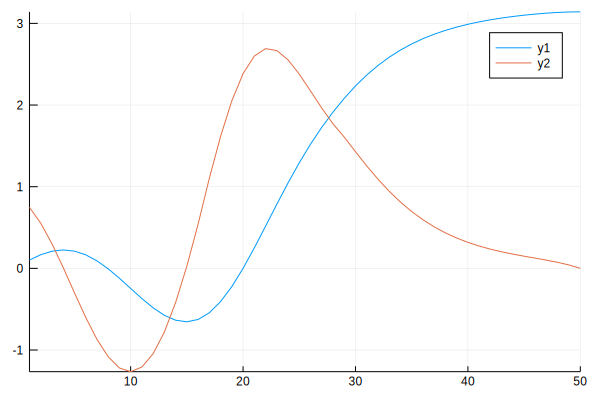

In [286]:
println(X_final[:,end])
plot(X_final')

[-3.15561e-7, -2.81844e-7, -2.36735e-7, -1.81326e-7, -1.16922e-7, -4.52408e-8, 3.14009e-8, 1.10076e-7, 1.87518e-7, 2.60607e-7, 3.26845e-7, 3.84478e-7, 4.32139e-7, 4.68058e-7, 4.89217e-7, 4.90897e-7, 4.67226e-7, 4.0864e-7, 3.1599e-7, 1.97959e-7, 7.03053e-8, -4.87514e-8, -1.44584e-7, -2.09995e-7, -2.45213e-7, -2.55294e-7, -2.47096e-7, -2.27129e-7, -2.00534e-7, -1.73105e-7, -1.46976e-7, -1.23273e-7, -1.02431e-7, -8.44676e-8, -6.9167e-8, -5.6208e-8, -4.52342e-8, -3.58931e-8, -2.78528e-8, -2.08075e-8, -1.44738e-8, -8.58446e-9, -2.87895e-9, 2.90803e-9, 9.05951e-9, 1.58916e-8, 2.37719e-8, 3.31418e-8, 4.45445e-8]


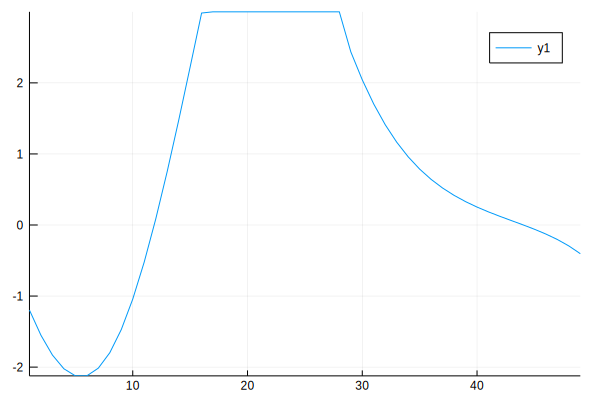

In [287]:
println(U_final[3,:])
plot(U_final[1,:])

In [288]:
anim = @animate for i=1:i_counter-1
    
    plt = plot(X_cache[:,:,i]',ylim=(-5,5),xlim=(0,solver.N),size=(200,200),label="",width=2,title="State Evolution")
    end 

gif(anim,"pendulum_infeasible_state_traj.gif",fps=5)

INFO: Saved animation to C:\Users\taylor howell\Google Drive\Stanford\Research-Manchester\iLQR (constrained)\pendulum_infeasible_state_traj.gif


Plots.AnimatedGif("C:\\Users\\taylor howell\\Google Drive\\Stanford\\Research-Manchester\\iLQR (constrained)\\pendulum_infeasible_state_traj.gif")

In [289]:
anim = @animate for i=1:i_counter-1
    
    plt = plot(U_cache[1,:,i],ylim=(-5,5),size=(200,200),label="",width=2,title="Control Evolution")
    end 

gif(anim,"pendulum_infeasible_control_traj.gif",fps=4)

INFO: Saved animation to C:\Users\taylor howell\Google Drive\Stanford\Research-Manchester\iLQR (constrained)\pendulum_infeasible_control_traj.gif


Plots.AnimatedGif("C:\\Users\\taylor howell\\Google Drive\\Stanford\\Research-Manchester\\iLQR (constrained)\\pendulum_infeasible_control_traj.gif")